# Preprocessing

## Daily

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2024, 1, 1)
btc_info = yf.Ticker("BTC-USD")

# pass the parameters as the taken dates for start and end
df_day = btc_info.history(start = start_date, end = end_date) 

In [3]:
fng_index = pd.read_csv("fng_index.csv")
fng_index["date"] = pd.to_datetime(fng_index.date, format = "%d-%m-%Y")
fng_index.set_index("date", inplace = True)

In [4]:
df_day = df_day.tz_localize(None)
df_day = pd.concat([df_day, fng_index], axis=1)
df_day.drop(columns = ["Dividends", "Stock Splits", "fng_classification"], inplace = True)
df_day.columns = ['open', 'high', 'low', 'close', 'Volume_BTC', 'fng_value']
df_day["Volume_BTC"] = df_day["Volume_BTC"]/df_day["close"]
df_day["Volume_BTC"] = np.log(df_day["Volume_BTC"] + 1)
df_day['RSI']=ta.rsi(df_day.close, length=15)
df_day['EMA'] = ta.ema(df_day.close, length=30)

In [6]:
df_day_diff = df_day.diff()
df_day_diff["Volume_BTC"] = df_day["Volume_BTC"].copy()
df_day_diff["RSI"] = df_day["RSI"].copy()
df_day_diff["EMA"] = df_day["EMA"].copy()
df_day_diff["fng_value"] = df_day["fng_value"].copy()
df_day_diff[["open", "high", "low", "close"]] = df_day_diff[["open", "high", "low", "close"]]/df_day[["open", "high", "low", "close"]].shift()
df_day_diff["EMA_return"] = ta.ema(df_day_diff.close, length = 10)

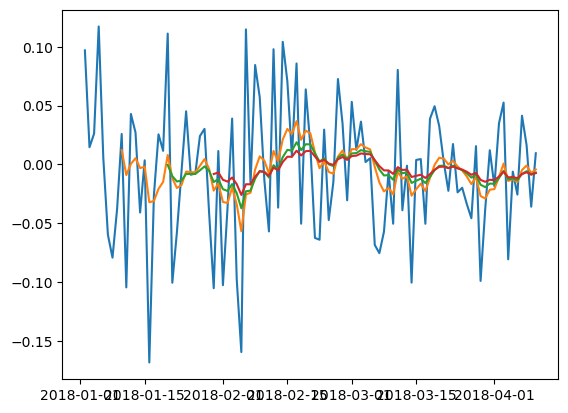

In [8]:
plt.plot(df_day_diff.close[:100])
plt.plot(ta.ema(df_day_diff.close, length = 10)[:100])
plt.plot(ta.ema(df_day_diff.close, length = 20)[:100])
plt.plot(ta.ema(df_day_diff.close, length = 30)[:100])

## Train-Test Split (Daily)

In [10]:
class preprocessing():
    def __init__(self, df):
        self.df = df
    
    def split(self, df, start, test_start, end):
        """Split df into df_train and df_test by training and testing period"""

        date_index = pd.to_datetime(df.index)
        mask_train = pd.Series(date_index).between(start, test_start, inclusive="left")
        df_train = df.loc[mask_train.values].copy(deep=True)

        mask_test = pd.Series(date_index).between(test_start, end, inclusive="left")
        df_test = df.loc[mask_test.values].copy(deep=True)

        return df_train, df_test
    
    def m_dist(self, df_train):
        """Compute Mahalanobis distance"""
        
        X = df_train.values
        m = X.mean(axis = 0)
        X_minus_m = X - m
        S = np.cov(X.T)
        S_inv = np.linalg.inv(S)
        maha_dist = np.array([X_minus_m[i]@S_inv@X_minus_m[i] for i in range(X.shape[0])])
        return maha_dist
    
    def outliers_indexing(self, df_train, quantile = 0.99):
        
        maha_dist = self.m_dist(df_train)
        is_outlier =  (maha_dist > np.quantile(maha_dist, quantile))
        return is_outlier

    def transform(self, df_train, df_test, method = "minmax", y_name = "close"):
        df_train = df_train.copy(deep=True)
        df_test = df_test.copy(deep=True)
        X_names = list(df_train.columns[df_train.columns != y_name])

        if method == "std":
            self.scaler_y = StandardScaler()
            self.scaler = StandardScaler()
        elif method == "minmax":
            self.scaler_y = MinMaxScaler()
            self.scaler = MinMaxScaler()
        
        self.scaler_y.fit(df_train[[y_name]])
        self.scaler.fit(df_train[X_names])
        df_train.loc[:, [y_name]] = self.scaler_y.transform(df_train[[y_name]])
        df_train.loc[:, X_names] = self.scaler.transform(df_train[X_names])
        df_test.loc[:, [y_name]] = self.scaler_y.transform(df_test[[y_name]])
        df_test.loc[:, X_names] = self.scaler.transform(df_test[X_names])

        return df_train, df_test
    
    def generate_dataset(self, df_train, seq_len, y_name = "close"):
        X_list, y_list = [], []
        for i in range(len(df_train.index) - seq_len):
            if df_train.iloc[i:i + 1 + seq_len,:].isna().any(axis = None):
                continue
            X_list.append(np.array(df_train.iloc[i:i+seq_len,:]))
            y_list.append(df_train[y_name].values[i+seq_len])
        return np.array(X_list), np.array(y_list)
    
    def pipeline(self, 
                 split_args = {"start": "2021-10-01", 
                               "test_start": "2021-12-31", 
                               "end" :"2022-01-01"}, 
                 outliers_indexing_args = {"quantile": 0.99}, 
                 transform_args = {"method": "minmax", 
                                   "y_name": "close"}, LAG = 5):
        self.df_train, self.df_test = self.split(self.df, **split_args)
        self.is_outlier = self.outliers_indexing(self.df_train, **outliers_indexing_args)
        self.df_train.iloc[self.is_outlier, :] = np.nan
        self.df_train_transformed, self.df_test_transformed = self.transform(self.df_train, self.df_test, **transform_args)
        
        # Add LAG number of observations in training dataset to test dataset
        df_test_LAG = pd.concat((self.df_train_transformed.iloc[-LAG:,:], self.df_test_transformed), axis=0)

        self.X_train, self.y_train = self.generate_dataset(self.df_train_transformed, seq_len=LAG)
        self.X_test, self.y_test = self.generate_dataset(df_test_LAG, seq_len=LAG)

In [12]:
df_day_diff[["close", "Volume_BTC", "fng_value", "RSI", "EMA", "EMA_return"]]

,close,Volume_BTC,fng_value,RSI,EMA,EMA_return
2018-01-01,NaN,13.532534,NaN,NaN,NaN,NaN
2018-01-02,0.097011,13.932804,NaN,NaN,NaN,NaN
2018-01-03,0.014611,13.919800,NaN,NaN,NaN,NaN
2018-01-04,0.026196,14.149431,NaN,NaN,NaN,NaN
2018-01-05,0.117333,14.128750,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-04-06,NaN,NaN,75.0,51.750421,41886.577281,-0.001882
2024-04-07,NaN,NaN,78.0,51.750421,41886.577281,-0.001882
2024-04-08,NaN,NaN,76.0,51.750421,41886.577281,-0.001882
2024-04-09,NaN,NaN,80.0,51.750421,41886.577281,-0.001882


In [42]:
split_args = {"start": "2018-01-01", 
              "test_start": "2023-01-01", 
              "end" :"2024-01-01"}

transform_args = {"method": "std", 
                  "y_name": "close"}
df_input = df_day_diff[["close", "Volume_BTC", "fng_value", "RSI", "EMA", "EMA_return"]]

pp_day_5 = preprocessing(df_input)
pp_day_5.pipeline(LAG = 5, split_args = split_args, transform_args = transform_args)

pp_day_10 = preprocessing(df_input)
pp_day_10.pipeline(LAG = 10, split_args = split_args, transform_args = transform_args)

pp_day_30 = preprocessing(df_input)
pp_day_30.pipeline(LAG = 30, split_args = split_args, transform_args = transform_args)

pp_day_90 = preprocessing(df_input)
pp_day_90.pipeline(LAG = 90, split_args = split_args, transform_args = transform_args)

pp_day_180 = preprocessing(df_input)
pp_day_180.pipeline(LAG = 180, split_args = split_args, transform_args = transform_args)

pp_day_360 = preprocessing(df_input)
pp_day_360.pipeline(LAG = 360, split_args = split_args, transform_args = transform_args)

In [43]:
X_train_day_5 = pp_day_5.X_train
X_test_day_5 = pp_day_5.X_test
y_train_day_5 = pp_day_5.y_train
y_test_day_5 = pp_day_5.y_test

X_train_day_10 = pp_day_10.X_train
X_test_day_10 = pp_day_10.X_test
y_train_day_10 = pp_day_10.y_train
y_test_day_10 = pp_day_10.y_test

X_train_day_30 = pp_day_30.X_train
X_test_day_30 = pp_day_30.X_test
y_train_day_30 = pp_day_30.y_train
y_test_day_30 = pp_day_30.y_test

X_train_day_90 = pp_day_90.X_train
X_test_day_90 = pp_day_90.X_test
y_train_day_90 = pp_day_90.y_train
y_test_day_90 = pp_day_90.y_test

X_train_day_180 = pp_day_180.X_train
X_test_day_180 = pp_day_180.X_test
y_train_day_180 = pp_day_180.y_train
y_test_day_180 = pp_day_180.y_test

X_train_day_360 = pp_day_360.X_train
X_test_day_360 = pp_day_360.X_test
y_train_day_360 = pp_day_360.y_train
y_test_day_360 = pp_day_360.y_test

In [46]:
X_train_day_360.shape

(1360, 360, 6)

In [49]:
pp_day_360.df_train.dropna()

,close,Volume_BTC,fng_value,RSI,EMA,EMA_return
2018-02-01,-0.102783,13.898032,30.0,30.777886,12743.654456,-0.031937
2018-02-02,-0.037052,14.180989,15.0,29.442144,12491.209008,-0.032867
2018-02-03,0.038973,13.581941,40.0,32.615766,12277.254243,-0.019805
2018-02-04,-0.097865,13.658392,24.0,28.972979,12019.173954,-0.033998
2018-02-05,-0.159688,14.104443,11.0,24.633706,11692.470474,-0.056850
...,...,...,...,...,...,...
2022-12-27,-0.011976,13.755825,27.0,44.954914,17011.908503,-0.001656
2022-12-28,-0.009846,13.842519,28.0,42.460302,16982.273907,-0.003145
2022-12-29,0.005423,13.675794,28.0,44.267447,16960.342804,-0.001587
2022-12-30,-0.002389,13.774105,28.0,43.617436,16937.261715,-0.001733


# Model

In [155]:
print(np.mean(y_train))
print(np.mean((y_train - np.mean(y_train))**2))
print(np.mean((y_test - np.mean(y_train))**2)**0.5)
print(np.mean((y_test - np.mean(y_test))**2))

0.5209902385970642
0.005115655311647604
0.06618702001498293
0.0043801554826098


In [50]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, AveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [51]:
metrics = [
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    tf.keras.metrics.RootMeanSquaredError(name='rmse')
]
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse', min_delta=0, patience=5, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)]

def model_builder_lstm(hp):
    hp_lstm_depth = hp.Int('lstm_depth', min_value=1, max_value=4, step=1)
    hp_lstm_size = hp.Choice('lstm_size', values = [8, 16, 32, 64])
    hp_lstm_dropout = hp.Choice('lstm_dropout', values = [0.2, 0.5, 0.8])

    hp_dense_depth = hp.Int('dense_depth', min_value=1, max_value=4, step=1)
    hp_dense_size = hp.Choice('dense_size', values = [8, 16, 32, 64])
    hp_dense_dropout = hp.Choice('dense_dropout', values = [0.2, 0.5, 0.8])

    hp_lr = 0.001
    #hp.Choice('learning_rate', values = [0.005, 0.001, 0.0005])
    
    model = Sequential()
    for i in range(hp_lstm_depth-1):
        model.add(LSTM(hp_lstm_size, return_sequences=True, dropout = hp_lstm_dropout))
    model.add(LSTM(hp_lstm_size, return_sequences=False, dropout = hp_lstm_dropout))
    
    for i in range(hp_dense_depth):
        model.add(Dense(hp_dense_size, activation = "relu"))
        model.add(Dropout(hp_dense_dropout))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss='mse',
        metrics = metrics
    )

    return model

In [87]:
def model_builder_conv_lstm(hp):
    hp_conv_filters = hp.Choice('conv_filters', values = [8, 16, 32, 64, 128])
    hp_conv_kernel_size = hp.Int('kernel_size', min_value=3, max_value=9, step=2)
    
    hp_lstm_depth = hp.Int('lstm_depth', min_value=2, max_value=4, step=1)
    hp_lstm_size = hp.Choice('lstm_size', values = [8, 16, 32, 64])
    hp_lstm_dropout = hp.Choice('lstm_dropout', values = [0.2, 0.5, 0.8])

    hp_dense_depth = hp.Int('dense_depth', min_value=1, max_value=4, step=1)
    hp_dense_size = hp.Choice('dense_size', values = [8, 16, 32, 64])
    hp_dense_dropout = hp.Choice('dense_dropout', values = [0.2, 0.5, 0.8])

    hp_lr = 0.001
    #hp.Choice('learning_rate', values = [0.005, 0.001, 0.0005])
    
    model = Sequential()
    model.add(Conv1D(hp_conv_filters, hp_conv_kernel_size, padding = "same"))
    model.add(MaxPooling1D(pool_size=2))

    for i in range(hp_lstm_depth-1):
        model.add(LSTM(hp_lstm_size, return_sequences=True, dropout = hp_lstm_dropout))
    model.add(LSTM(hp_lstm_size, return_sequences=False, dropout = hp_lstm_dropout))
    
    for i in range(hp_dense_depth):
        model.add(Dense(hp_dense_size, activation = "relu"))
        model.add(Dropout(hp_dense_dropout))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss='mse',
        metrics = metrics
    )

    return model

In [52]:
test_close = df_day[(df_day.index >= "2023-01-01")*(df_day.index < "2024-01-01")].close.copy()
naive_pred = df_day[(df_day.index >= "2022-12-31")*(df_day.index < "2023-12-31")].close.values

## Daily

### Lag 5

#### Lstm

In [58]:
tuner_day_5 = kt.RandomSearch(
    model_builder_lstm,
    objective = 'val_loss',
    max_trials = 50,  # Number of different configurations to try
    executions_per_trial = 1,  # Number of models to train for each trial
    seed = 4012,
    overwrite = True
)

In [60]:
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse', min_delta=0, patience=10, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)]
tuner_day_5.search(
    X_train_day_5[:(len(X_train_day_5)-100)], y_train_day_5[:(len(y_train_day_5)-100)],
    epochs=50,
    validation_data = (X_train_day_5[-100:], y_train_day_5[-100:]),
    callbacks=callbacks
)

Trial 50 Complete [00h 00m 07s]
val_loss: 0.3728318214416504

Best val_loss So Far: 0.3553650975227356
Total elapsed time: 00h 06m 22s


In [69]:
tf.keras.utils.set_random_seed(4012)
best_hps_day_5 = tuner_day_5.get_best_hyperparameters(num_trials=1)[0]
model_day_5 = tuner_day_5.hypermodel.build(best_hps_day_5)
model_day_5.fit(X_train_day_5, y_train_day_5,
                batch_size=64, epochs=10)
pred_return_day_5 = pp_day_5.scaler_y.inverse_transform(model_day_5.predict(X_test_day_5))[:,0]
pred_close_day_5 = naive_pred*(pred_return_day_5+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model_day_5: {np.mean((test_close - pred_close_day_5)**2)}")

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9533 - mae: 0.5744 - rmse: 0.8621 
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9562 - mae: 0.6616 - rmse: 0.9770 
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9495 - mae: 0.6594 - rmse: 0.9737 
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9462 - mae: 0.6583 - rmse: 0.9720 
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9429 - mae: 0.6568 - rmse: 0.9703 
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9467 - mae: 0.6597 - rmse: 0.9722 
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9442 - mae: 0.6570 - rmse: 0.9709 
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9506 - mae: 0.6588 - rmse: 0.9742 
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9512 - mae: 0.6611 - rmse: 0.9745 
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9463 - mae: 0.6574 - rmse: 0.9720 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
naive: 43

In [67]:
best_hps_day_5.values

{'lstm_depth': 1,
 'lstm_size': 8,
 'lstm_dropout': 0.2,
 'dense_depth': 4,
 'dense_size': 32,
 'dense_dropout': 0.2}

In [70]:
model_day_5.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 8)              │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,909 (46.52 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,940 (31.02 KB)

### Lag 10

#### Lstm

### Lag 30

#### Lstm

In [71]:
tuner_day_30 = kt.RandomSearch(
    model_builder_lstm,
    objective = 'val_loss',
    max_trials = 50,  # Number of different configurations to try
    executions_per_trial = 1,  # Number of models to train for each trial
    seed = 4012,
    overwrite = True
)

In [72]:
tuner_day_30.search(
    X_train_day_30[:(len(X_train_day_30)-100)], y_train_day_30[:(len(y_train_day_30)-100)],
    epochs=50,
    validation_data = (X_train_day_30[-100:], y_train_day_30[-100:]),
    callbacks=callbacks
)

Trial 50 Complete [00h 00m 12s]
val_loss: 0.37423720955848694

Best val_loss So Far: 0.36132171750068665
Total elapsed time: 00h 10m 03s


In [182]:
tf.keras.utils.set_random_seed(4019)
best_hps_day_30 = tuner_day_30.get_best_hyperparameters(num_trials=1)[0]
model_day_30 = tuner_day_30.hypermodel.build(best_hps_day_30)
model_day_30.fit(X_train_day_30, y_train_day_30,
                batch_size=64, epochs=10, validation_data = (X_test_day_30, y_test_day_30))
pred_return_day_30 = pp_day_30.scaler_y.inverse_transform(model_day_30.predict(X_test_day_30))[:,0]
pred_close_day_30 = naive_pred*(pred_return_day_30+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model_day_30: {np.mean((test_close - pred_close_day_30)**2)}")

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9261 - mae: 0.5853 - rmse: 0.8635 - val_loss: 0.3585 - val_mae: 0.4000 - val_rmse: 0.6001
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8759 - mae: 0.6389 - rmse: 0.9350 - val_loss: 0.3592 - val_mae: 0.4007 - val_rmse: 0.6004
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8795 - mae: 0.6364 - rmse: 0.9369 - val_loss: 0.3589 - val_mae: 0.4012 - val_rmse: 0.6001
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8760 - mae: 0.6382 - rmse: 0.9354 - val_loss: 0.3584 - val_mae: 0.4012 - val_rmse: 0.5999
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8758 - mae: 0.6370 - rmse: 0.9350 - val_loss: 0.3594 - val_mae: 0.3998 - val_rmse: 0.6004
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8698 - mae: 0.6355 - rmse: 0.9319 - val_loss: 0.3610 - val_mae: 0.4002 - val_rmse: 0.6016
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8839 - mae: 0.6406 - rmse: 0.9396 - val

In [81]:
best_hps_day_30.values

{'lstm_depth': 1,
 'lstm_size': 32,
 'lstm_dropout': 0.2,
 'dense_depth': 1,
 'dense_size': 8,
 'dense_dropout': 0.5}

In [203]:
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse', min_delta=0, patience=5, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)]
tf.keras.utils.set_random_seed(4012)
hp_lstm_depth = 2
hp_lstm_size = 8
hp_lstm_dropout = 0.5

hp_dense_depth = 1
hp_dense_size = 4
hp_dense_dropout = 0.5

hp_lr = 0.001
    
model = Sequential()
model.add(LSTM(hp_lstm_size, return_sequences=True))
model.add(LSTM(hp_lstm_size, return_sequences=True, dropout = hp_lstm_dropout))
model.add(LSTM(hp_lstm_size, return_sequences=True, dropout = hp_lstm_dropout))
model.add(LSTM(hp_lstm_size, return_sequences=False, dropout = hp_lstm_dropout))
model.add(Dense(1))

model.compile(optimizer = Adam(learning_rate = hp_lr), loss='mse', metrics = metrics)
model.fit(X_train_day_5[:(len(y_train_day_5)-100), :, [1,2,3,4]], y_train_day_5[:(len(y_train_day_5)-100)]
          , batch_size=64, epochs=100, shuffle=True, validation_data = (X_train_day_5[-100:, :, [1,2,3,4]], y_train_day_5[-100:]), callbacks = callbacks)
test_close = df_day[(df_day.index >= "2023-01-01")*(df_day.index < "2024-01-01")].close.copy()
naive_pred = df_day[(df_day.index >= "2022-12-31")*(df_day.index < "2023-12-31")].close.values
pred_return = pp_day_5.scaler_y.inverse_transform(model.predict(X_test_day_5[:,:,[1,2,3,4]]))[:,0]
pred_close = naive_pred*(pred_return+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model: {np.mean((test_close - pred_close)**2)}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.9592 - mae: 0.6574 - rmse: 0.9716 - val_loss: 0.4091 - val_mae: 0.4256 - val_rmse: 0.6905
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9656 - mae: 0.6745 - rmse: 0.9825 - val_loss: 0.4066 - val_mae: 0.4212 - val_rmse: 0.6884
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9643 - mae: 0.6721 - rmse: 0.9818 - val_loss: 0.4062 - val_mae: 0.4205 - val_rmse: 0.6880
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9621 - mae: 0.6724 - rmse: 0.9807 - val_loss: 0.4061 - val_mae: 0.4203 - val_rmse: 0.6879
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9627 - mae: 0.6726 - rmse: 0.9810 - val_loss: 0.4059 - val_mae: 0.4200 - val_rmse: 0.6878
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9626 - mae: 0.6714 - rmse: 0.9809 - val_loss: 0.4059 - val_mae: 0.4198 - val_rmse: 0.6877
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9596 - mae: 0.6708 - rmse: 0.979

In [146]:
X_train_day_5

(1782, 5, 6)

In [144]:
df_day_diff

,open,high,low,close,Volume_BTC,fng_value,RSI,EMA,EMA_return
2018-01-01,NaN,NaN,NaN,NaN,13.532534,NaN,NaN,NaN,NaN
2018-01-02,-0.034523,0.094415,0.000677,0.097011,13.932804,NaN,NaN,NaN,NaN
2018-01-03,0.099317,0.008301,0.127693,0.014611,13.919800,NaN,NaN,NaN,NaN
2018-01-04,0.019528,0.010717,-0.021712,0.026196,14.149431,NaN,NaN,NaN,NaN
2018-01-05,0.013523,0.124875,0.046866,0.117333,14.128750,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-04-06,NaN,NaN,NaN,NaN,NaN,75.0,51.750421,41886.577281,-0.001882
2024-04-07,NaN,NaN,NaN,NaN,NaN,78.0,51.750421,41886.577281,-0.001882
2024-04-08,NaN,NaN,NaN,NaN,NaN,76.0,51.750421,41886.577281,-0.001882
2024-04-09,NaN,NaN,NaN,NaN,NaN,80.0,51.750421,41886.577281,-0.001882


In [138]:
len(y_train_day_5)

1782

In [40]:
model.add(BatchNormalization())

<Sequential name=sequential_12, built=True>

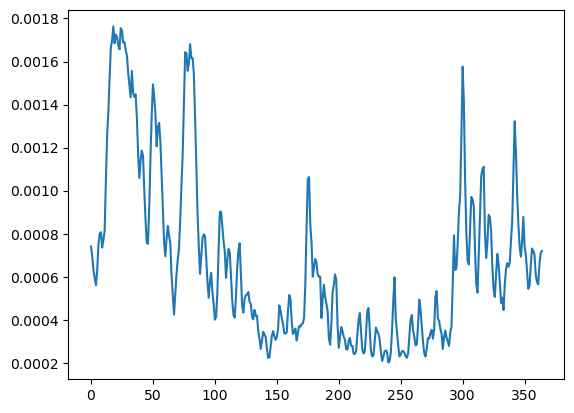

In [204]:
plt.plot(pred_return)

In [48]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 30, 8)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 30, 8)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 30, 8)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,621 (25.87 KB)

 Trainable params: 2,185 (8.54 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 4,372 (17.08 KB)

#### Conv1D-Lstm

In [92]:
tuner_day_30_CL = kt.RandomSearch(
    model_builder_conv_lstm,
    objective='val_loss',
    max_trials=30,  # Number of different configurations to try
    executions_per_trial=1,  # Number of models to train for each trial
    seed = 4012,
    overwrite=True
)

In [94]:
tuner_day_30_CL.search(
    X_train_day_30, y_train_day_30,
    epochs=10,
    validation_split = 0.1
)

Trial 30 Complete [00h 00m 10s]
val_loss: 0.5308324694633484

Best val_loss So Far: 0.5267766714096069
Total elapsed time: 00h 04m 35s


In [117]:
tf.keras.utils.set_random_seed(4019)
best_hps_day_30_CL = tuner_day_30_CL.get_best_hyperparameters(num_trials=1)[0]
model_day_30_CL = tuner_day_30_CL.hypermodel.build(best_hps_day_30_CL)
model_day_30_CL.fit(X_train_day_30, y_train_day_30,
                batch_size=64, epochs=10)
pred_return_day_30_CL = pp_day_30.scaler_y.inverse_transform(model_day_30_CL.predict(X_test_day_30))[:,0]
pred_close_day_30_CL = naive_pred*(pred_return_day_30_CL+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model_day_30_CL: {np.mean((test_close - pred_close_day_30_CL)**2)}")

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.8717 - mae: 0.6491 - rmse: 0.9617
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8779 - mae: 0.6396 - rmse: 0.9362
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8730 - mae: 0.6395 - rmse: 0.9335
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8761 - mae: 0.6408 - rmse: 0.9352
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8787 - mae: 0.6430 - rmse: 0.9366
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8767 - mae: 0.6400 - rmse: 0.9354
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8755 - mae: 0.6378 - rmse: 0.9348
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8748 - mae: 0.6393 - rmse: 0.9346
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8794 - mae: 0.6413 - rmse: 0.9370
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8833 - mae: 0.6406 - rmse: 0.9390
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
naive: 430132.64579

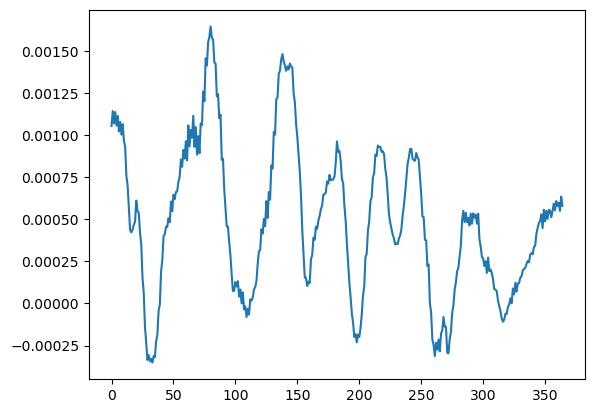

In [109]:
plt.plot(pred_return_day_30_CL)

In [368]:
print(f"naive: {np.mean(abs(naive_pred/test_close-1))}")
print(f"model: {np.mean(abs(pred_close/test_close-1))}")

naive: 0.015177906984877114
model: 0.015209226193191367


In [96]:
best_hps_day_30_CL.values

{'conv_filters': 128,
 'kernel_size': 7,
 'lstm_depth': 4,
 'lstm_size': 32,
 'lstm_dropout': 0.5,
 'dense_depth': 2,
 'dense_size': 32,
 'dense_dropout': 0.2}

### Lag 90

#### Lstm

In [110]:
tuner_day_90= kt.RandomSearch(
    model_builder_lstm,
    objective = 'val_loss',
    max_trials = 50,  # Number of different configurations to try
    executions_per_trial = 1,  # Number of models to train for each trial
    seed = 4012,
    overwrite = True
)

In [119]:
tuner_day_90.search(
    X_train_day_90[:(len(X_train_day_90)-100)], y_train_day_90[:(len(y_train_day_90)-100)],
    epochs=10,
    validation_data = (X_train_day_90[-100:], y_train_day_90[-100:]),
)

Trial 50 Complete [00h 00m 13s]
val_loss: 0.3785862922668457

Best val_loss So Far: 0.3671008348464966
Total elapsed time: 00h 15m 00s


In [121]:
tf.keras.utils.set_random_seed(4012)
best_hps_day_90 = tuner_day_90.get_best_hyperparameters(num_trials=1)[0]
model_day_90 = tuner_day_90.hypermodel.build(best_hps_day_90)
model_day_90.fit(X_train_day_90, y_train_day_90,
                batch_size=64, epochs=10, validation_data = (X_test_day_90, y_test_day_90))
pred_return_day_90 = pp_day_90.scaler_y.inverse_transform(model_day_90.predict(X_test_day_90))[:,0]
pred_close_day_90 = naive_pred*(pred_return_day_90+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model_day_90: {np.mean((test_close - pred_close_day_90)**2)}")

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.8943 - mae: 0.5649 - rmse: 0.8408 - val_loss: 0.3570 - val_mae: 0.4054 - val_rmse: 0.5991
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9159 - mae: 0.6595 - rmse: 0.9570 - val_loss: 0.3560 - val_mae: 0.4030 - val_rmse: 0.5980
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9099 - mae: 0.6498 - rmse: 0.9539 - val_loss: 0.3542 - val_mae: 0.4049 - val_rmse: 0.5965
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9005 - mae: 0.6408 - rmse: 0.9489 - val_loss: 0.3538 - val_mae: 0.4047 - val_rmse: 0.5962
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8970 - mae: 0.6434 - rmse: 0.9470 - val_loss: 0.3538 - val_mae: 0.4023 - val_rmse: 0.5962
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8792 - mae: 0.6404 - rmse: 0.9375 - val_loss: 0.3545 - val_mae: 0.4014 - val_rmse: 0.5968
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8788 - mae: 0.6428 - rmse: 0.9372

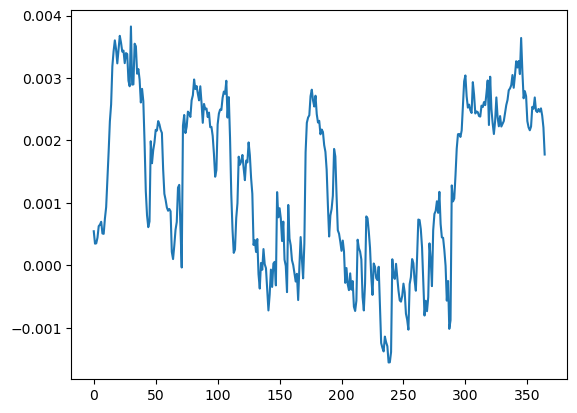

In [122]:
plt.plot(pred_return_day_90)

#### Conv1D-Lstm

In [124]:
def model_builder_conv_lstm2(hp):
    hp_conv_depth = hp.Int('conv_size', min_value=1, max_value=3, step=1)
    hp_conv_filters = hp.Choice('conv_filters', values = [8, 16, 32, 64, 128])
    hp_conv_kernel_size = hp.Int('kernel_size', min_value = 3, max_value = 33, step = 5)
    
    hp_lstm_depth = hp.Int('lstm_depth', min_value=2, max_value=4, step=1)
    hp_lstm_size = hp.Choice('lstm_size', values = [8, 16, 32, 64])
    hp_lstm_dropout = hp.Choice('lstm_dropout', values = [0.2, 0.5, 0.8])

    hp_dense_depth = hp.Int('dense_depth', min_value=1, max_value=4, step=1)
    hp_dense_size = hp.Choice('dense_size', values = [8, 16, 32, 64])
    hp_dense_dropout = hp.Choice('dense_dropout', values = [0.2, 0.5, 0.8])

    hp_lr = 0.001
    #hp.Choice('learning_rate', values = [0.005, 0.001, 0.0005])
    
    model = Sequential()
    for i in range(hp_conv_depth):
        model.add(Conv1D(hp_conv_filters, hp_conv_kernel_size, padding = "same", activation = "relu"))
        model.add(AveragePooling1D(pool_size=2))

    for i in range(hp_lstm_depth-1):
        model.add(LSTM(hp_lstm_size, return_sequences=True, dropout = hp_lstm_dropout))
    model.add(LSTM(hp_lstm_size, return_sequences=False, dropout = hp_lstm_dropout))
    
    for i in range(hp_dense_depth):
        model.add(Dense(hp_dense_size, activation = "relu"))
        model.add(Dropout(hp_dense_dropout))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss='mse',
        metrics = metrics
    )

    return model

In [126]:
tuner_day_90_CL = kt.RandomSearch(
    model_builder_conv_lstm2,
    objective='val_loss',
    max_trials=30,  # Number of different configurations to try
    executions_per_trial=1,  # Number of models to train for each trial
    seed = 4012,
    overwrite=True
)

In [127]:
tuner_day_90_CL.search(
    X_train_day_90, y_train_day_90,
    epochs=10,
    validation_split = 0.1
)

Trial 30 Complete [00h 00m 12s]
val_loss: 0.4723556935787201

Best val_loss So Far: 0.4709326922893524
Total elapsed time: 00h 06m 04s


In [134]:
tf.keras.utils.set_random_seed(4019)
best_hps_day_90_CL = tuner_day_90_CL.get_best_hyperparameters(num_trials=1)[0]
model_day_90_CL = tuner_day_90_CL.hypermodel.build(best_hps_day_90_CL)
model_day_90_CL.fit(X_train_day_90, y_train_day_90,
                batch_size=64, epochs=10)
pred_return_day_90_CL = pp_day_90.scaler_y.inverse_transform(model_day_90_CL.predict(X_test_day_90))[:,0]
pred_close_day_90_CL = naive_pred*(pred_return_day_90_CL+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model_day_90_CL: {np.mean((test_close - pred_close_day_90_CL)**2)}")

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 1.0170 - mae: 0.6521 - rmse: 0.9782
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0048 - mae: 0.6600 - rmse: 1.0019
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0061 - mae: 0.6629 - rmse: 1.0026
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0073 - mae: 0.6592 - rmse: 1.0032
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0119 - mae: 0.6613 - rmse: 1.0054
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0108 - mae: 0.6610 - rmse: 1.0049
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0065 - mae: 0.6586 - rmse: 1.0027
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0092 - mae: 0.6591 - rmse: 1.0041
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0125 - mae: 0.6608 - rmse: 1.0057
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0076 - mae: 0.6586 - rmse: 1.0033
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
naive: 4

In [184]:
best_hps_day_90_CL.values

{'conv_size': 3,
 'conv_filters': 128,
 'kernel_size': 33,
 'lstm_depth': 3,
 'lstm_size': 64,
 'lstm_dropout': 0.2,
 'dense_depth': 1,
 'dense_size': 32,
 'dense_dropout': 0.2}

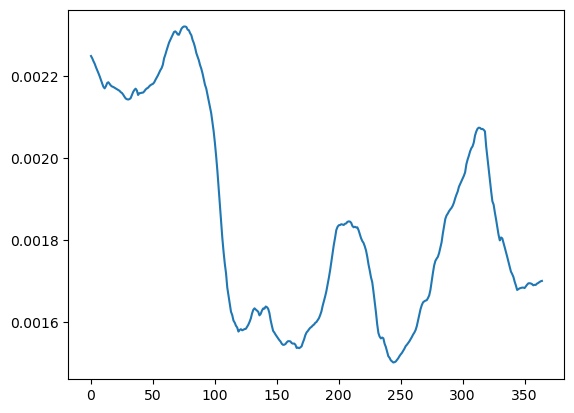

In [144]:
plt.plot(pred_return_day_90_CL)

### Lag 180

#### Lstm

In [137]:
tuner_day_180= kt.RandomSearch(
    model_builder_lstm,
    objective = 'val_loss',
    max_trials = 50,  # Number of different configurations to try
    executions_per_trial = 1,  # Number of models to train for each trial
    seed = 4012,
    overwrite = True
)

In [139]:
tuner_day_180.search(
    X_train_day_180, y_train_day_180,
    epochs=10,
    validation_split = 0.1,
)

Trial 50 Complete [00h 00m 19s]
val_loss: 0.5226165056228638

Best val_loss So Far: 0.5192965269088745
Total elapsed time: 00h 23m 25s


In [171]:
tf.keras.utils.set_random_seed(4012)
best_hps_day_180 = tuner_day_180.get_best_hyperparameters(num_trials=1)[0]
model_day_180 = tuner_day_180.hypermodel.build(best_hps_day_180)
model_day_180.fit(X_train_day_180, y_train_day_180,
                batch_size=64, epochs=10)
pred_return_day_180 = pp_day_180.scaler_y.inverse_transform(model_day_180.predict(X_test_day_180))[:,0]
pred_close_day_180 = naive_pred*(pred_return_day_180+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model_day_180: {np.mean((test_close - pred_close_day_180)**2)}")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.9625 - mae: 0.6570 - rmse: 0.9812
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.9494 - mae: 0.6506 - rmse: 0.9733
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.9487 - mae: 0.6531 - rmse: 0.9730
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.9308 - mae: 0.6469 - rmse: 0.9638
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.9463 - mae: 0.6530 - rmse: 0.9716
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.9484 - mae: 0.6534 - rmse: 0.9729
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.9455 - mae: 0.6542 - rmse: 0.9715
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.9431 - mae: 0.6508 - rmse: 0.9702
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.9435 - mae: 0.6512 - rmse: 0.9704
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.9471 - mae: 0.6519 - rmse: 0.9722
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


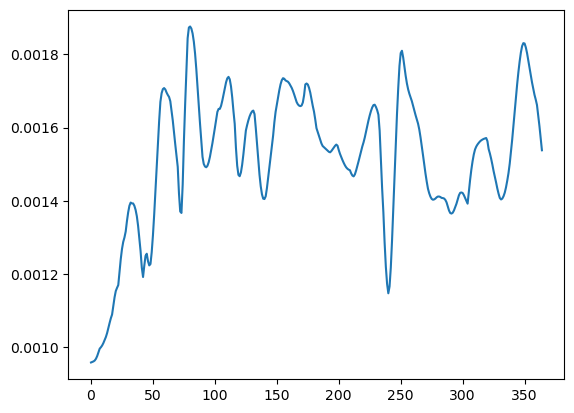

In [174]:
plt.plot(pred_return_day_180)

#### Conv1D-Lstm

In [160]:
def model_builder_conv_lstm3(hp):
    hp_conv_depth = hp.Int('conv_size', min_value=1, max_value=4, step=1)
    hp_conv_filters = hp.Choice('conv_filters', values = [8, 16, 32, 64, 128])
    hp_conv_kernel_size = hp.Int('kernel_size', min_value = 3, max_value = 31, step = 4)
    
    hp_lstm_depth = hp.Int('lstm_depth', min_value=2, max_value=4, step=1)
    hp_lstm_size = hp.Choice('lstm_size', values = [8, 16, 32, 64])
    hp_lstm_dropout = hp.Choice('lstm_dropout', values = [0.2, 0.5, 0.8])

    hp_dense_depth = hp.Int('dense_depth', min_value=1, max_value=4, step=1)
    hp_dense_size = hp.Choice('dense_size', values = [8, 16, 32, 64])
    hp_dense_dropout = hp.Choice('dense_dropout', values = [0.2, 0.5, 0.8])

    hp_lr = 0.001
    #hp.Choice('learning_rate', values = [0.005, 0.001, 0.0005])
    
    model = Sequential()
    for i in range(hp_conv_depth):
        model.add(Conv1D(hp_conv_filters, hp_conv_kernel_size, padding = "same", activation = "relu"))
        model.add(AveragePooling1D(pool_size=2))

    for i in range(hp_lstm_depth-1):
        model.add(LSTM(hp_lstm_size, return_sequences=True, dropout = hp_lstm_dropout))
    model.add(LSTM(hp_lstm_size, return_sequences=False, dropout = hp_lstm_dropout))
    
    for i in range(hp_dense_depth):
        model.add(Dense(hp_dense_size, activation = "relu"))
        model.add(Dropout(hp_dense_dropout))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss='mse',
        metrics = metrics
    )

    return model

In [165]:
tuner_day_180_CL = kt.RandomSearch(
    model_builder_conv_lstm3,
    objective='val_loss',
    max_trials=30,  # Number of different configurations to try
    executions_per_trial=1,  # Number of models to train for each trial
    seed = 4012,
    overwrite=True
)

In [166]:
tuner_day_180_CL.search(
    X_train_day_180, y_train_day_180,
    epochs=10,
    validation_split = 0.1
)

Trial 30 Complete [00h 00m 16s]
val_loss: 0.5241175293922424

Best val_loss So Far: 0.5194797515869141
Total elapsed time: 00h 07m 53s


In [172]:
tf.keras.utils.set_random_seed(4012)
best_hps_day_180_CL = tuner_day_180_CL.get_best_hyperparameters(num_trials=1)[0]
model_day_180_CL = tuner_day_180_CL.hypermodel.build(best_hps_day_180_CL)
model_day_180_CL.fit(X_train_day_180, y_train_day_180,
                batch_size=64, epochs=10)
pred_return_day_180_CL = pp_day_180.scaler_y.inverse_transform(model_day_180_CL.predict(X_test_day_180))[:,0]
pred_close_day_180_CL = naive_pred*(pred_return_day_180_CL+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model_day_180_CL: {np.mean((test_close - pred_close_day_180_CL)**2)}")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.9505 - mae: 0.6548 - rmse: 0.9783
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.9416 - mae: 0.6561 - rmse: 0.9694
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.9399 - mae: 0.6499 - rmse: 0.9685
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.9434 - mae: 0.6507 - rmse: 0.9702
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.9444 - mae: 0.6512 - rmse: 0.9708
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.9416 - mae: 0.6486 - rmse: 0.9693
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.9409 - mae: 0.6492 - rmse: 0.9690
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.9410 - mae: 0.6498 - rmse: 0.9691
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.9439 - mae: 0.6510 - rmse: 0.9706
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.9401 - mae: 0.6489 - rmse: 0.9686
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
naive: 43

In [169]:
model_day_180_CL.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 180, 128)       │        23,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 90, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 90, 128)        │       508,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 45, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 45, 128)        │       508,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_4             │ (None, 22, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 22, 128)        │       508,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 11, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 11, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 11, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,996,805 (19.06 MB)

 Trainable params: 1,665,601 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,331,204 (12.71 MB)

In [168]:
best_hps_day_180_CL.values

{'conv_size': 4,
 'conv_filters': 128,
 'kernel_size': 31,
 'lstm_depth': 3,
 'lstm_size': 64,
 'lstm_dropout': 0.2,
 'dense_depth': 1,
 'dense_size': 32,
 'dense_dropout': 0.2}

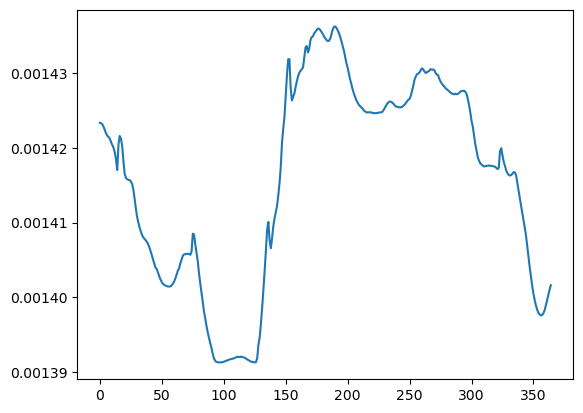

In [173]:
plt.plot(pred_return_day_180_CL)

In [ ]:
print(f"naive: {np.mean((test_close - naive_pred)**2)**0.5}")
print(f"model_day_90_CL: {np.mean((test_close - pred_close_day_90_CL)**2)**0.5}")

naive: 655.8449861033743
model_day_90_CL: 652.2962184834252


# result

In [201]:
df_pred_return = pd.DataFrame([pred_return_day_5, 
                               pred_return_day_30, pred_return_day_30_CL,
                               pred_return_day_90, pred_return_day_90_CL,
                               pred_return_day_180, pred_return_day_180_CL]).T
df_pred_return.columns = ["LSTM_5",
                          "LSTM_30", "Conv1D_LSTM_30",
                          "LSTM_90", "Conv1D_LSTM_90",
                          "LSTM_180", "Conv1D_LSTM_180"]
df_pred_return.index = pp_day_90.df_test.index

In [205]:
naive_pred

array([16547.49609375, 16625.08007812, 16688.47070312, 16679.85742188,
       16863.23828125, 16836.73632812, 16951.96875   , 16955.078125  ,
       17091.14453125, 17196.5546875 , 17446.29296875, 17934.89648438,
       18869.58789062, 19909.57421875, 20976.29882812, 20880.79882812,
       21169.6328125 , 21161.51953125, 20688.78125   , 21086.79296875,
       22676.55273438, 22777.625     , 22720.41601562, 22934.43164062,
       22636.46875   , 23117.859375  , 23032.77734375, 23078.72851562,
       23031.08984375, 23774.56640625, 22840.13867188, 23139.28320312,
       23723.76953125, 23471.87109375, 23449.32226562, 23331.84765625,
       22955.66601562, 22760.109375  , 23264.29101562, 22939.3984375 ,
       21819.0390625 , 21651.18359375, 21870.875     , 21788.203125  ,
       21808.1015625 , 22220.8046875 , 24307.84179688, 23623.47460938,
       24565.6015625 , 24641.27734375, 24327.64257812, 24829.1484375 ,
       24436.35351562, 24188.84375   , 23947.4921875 , 23198.12695312,
      

In [235]:
df_pred_return.apply(lambda col: (1+col)*naive_pred).to_csv("LSTM_Conv_result.csv")

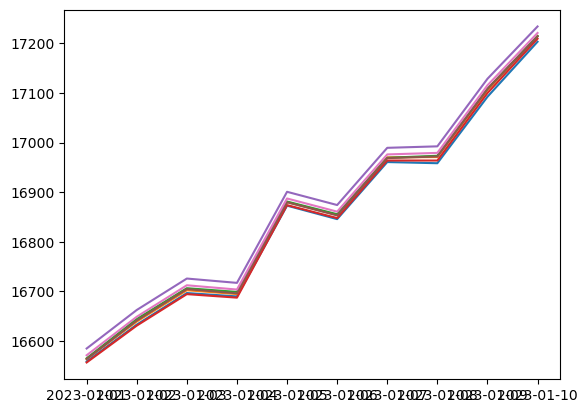

In [238]:
plt.plot(df_pred_return.apply(lambda col: (1+col)*naive_pred)[:10])

Text(0.5, 1.0, 'Prediction on Daily Change in Price')

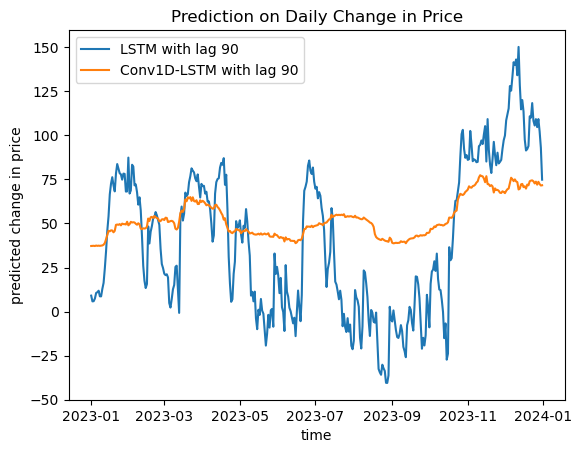

In [220]:
plt.plot(df_pred_return[["LSTM_90", "Conv1D_LSTM_90"]].apply(lambda col: col*naive_pred), label = ["LSTM with lag 90", "Conv1D-LSTM with lag 90"])
plt.legend()
plt.ylabel("predicted change in price")
plt.xlabel("time")
plt.title("Prediction on Daily Change in Price")

In [222]:
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse', min_delta=0, patience=5, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)]
tf.keras.utils.set_random_seed(4012)
   
model = Sequential()
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation = "relu"))
model.add(Dropout(0))
model.add(Dense(16, activation = "relu"))
model.add(Dropout(0))
model.add(Dense(1))

model.compile(optimizer = Adam(learning_rate = hp_lr), loss='mse', metrics = metrics)
model.fit(X_train_day_90, y_train_day_90, batch_size=64, epochs=50, shuffle=True)
pred_return = pp_day_90.scaler_y.inverse_transform(model.predict(X_test_day_90))[:,0]
pred_close = naive_pred*(pred_return+1)
print(f"naive: {np.mean((test_close - naive_pred)**2)}")
print(f"model: {np.mean((test_close - pred_close)**2)}")

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.8769 - mae: 0.6422 - rmse: 0.9595
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8690 - mae: 0.6319 - rmse: 0.9320
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8675 - mae: 0.6316 - rmse: 0.9312
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8645 - mae: 0.6307 - rmse: 0.9296
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8635 - mae: 0.6304 - rmse: 0.9291
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8601 - mae: 0.6293 - rmse: 0.9272
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8577 - mae: 0.6287 - rmse: 0.9260
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8545 - mae: 0.6283 - rmse: 0.9242
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8536 - mae: 0.6280 - rmse: 0.9238
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8510 - mae: 0.6272 - rmse: 0.9223
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/st

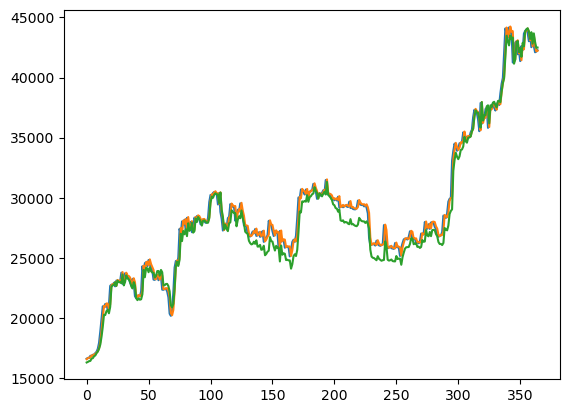

In [233]:
plt.plot(test_close.values)
plt.plot(pred_close_day_90_CL)
plt.plot(pred_close)